This notebook is for performing prediction performance evaluation on different datasets.

See caption in the codes for more details.

In [ ]:
import os
import sys
import glob

import pandas as pd
import numpy as np
import json

from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
from scipy.spatial.distance import jaccard
import math

from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
main_folder = "/home/data/grd22/AgreementPred_Codes"

In [ ]:
#Mapping representation names used in codes to the ones used in the article

fps = pd.read_csv(f"{main_folder}/Data/29FP_lst.csv")
fp_dict = {f:n for f,n in zip(fps['fp'], fps['name'])}
fp_dict

{'rdkitTT': 'TT',
 'rdkitAP': 'AP',
 'rdkitAvalon': 'Avalon',
 'rdkitRDKIT': 'RDKIT',
 'jmapDFS': 'DFS',
 'jmapASP': 'ASP',
 'cdkDaylight': 'Daylight',
 'cdkFP': 'CDKFP',
 'ExtFP': 'ExtFP',
 'HybridFP': 'HybridFP',
 'SPFP': 'SPFP',
 'AP2DFP': 'AP2DFP',
 'GraphFP': 'GraphFP',
 'InfoGraphFeature': 'InfoGraph',
 'CircFP': 'CircFP',
 'jmapLSTAR': 'LSTAR',
 'jmapRAD2D': 'RAD2D',
 'rdkitECFP': 'EC1024',
 'rdkitFCFP': 'FC1024',
 'MorganFP': 'EC2048',
 'EStateFP': 'EstateFP',
 'KRFP': 'KRFP',
 'PubchemFP': 'PubchemFP',
 'maccsFP': 'MACCSFP',
 'LingoFP': 'LingoFP',
 'minhashMHFP': 'MHFP',
 'minhashMAP4': 'MAP4',
 'jmapPH2': 'PH2',
 'jmapPH3': 'PH3'}

For iSEA dataset

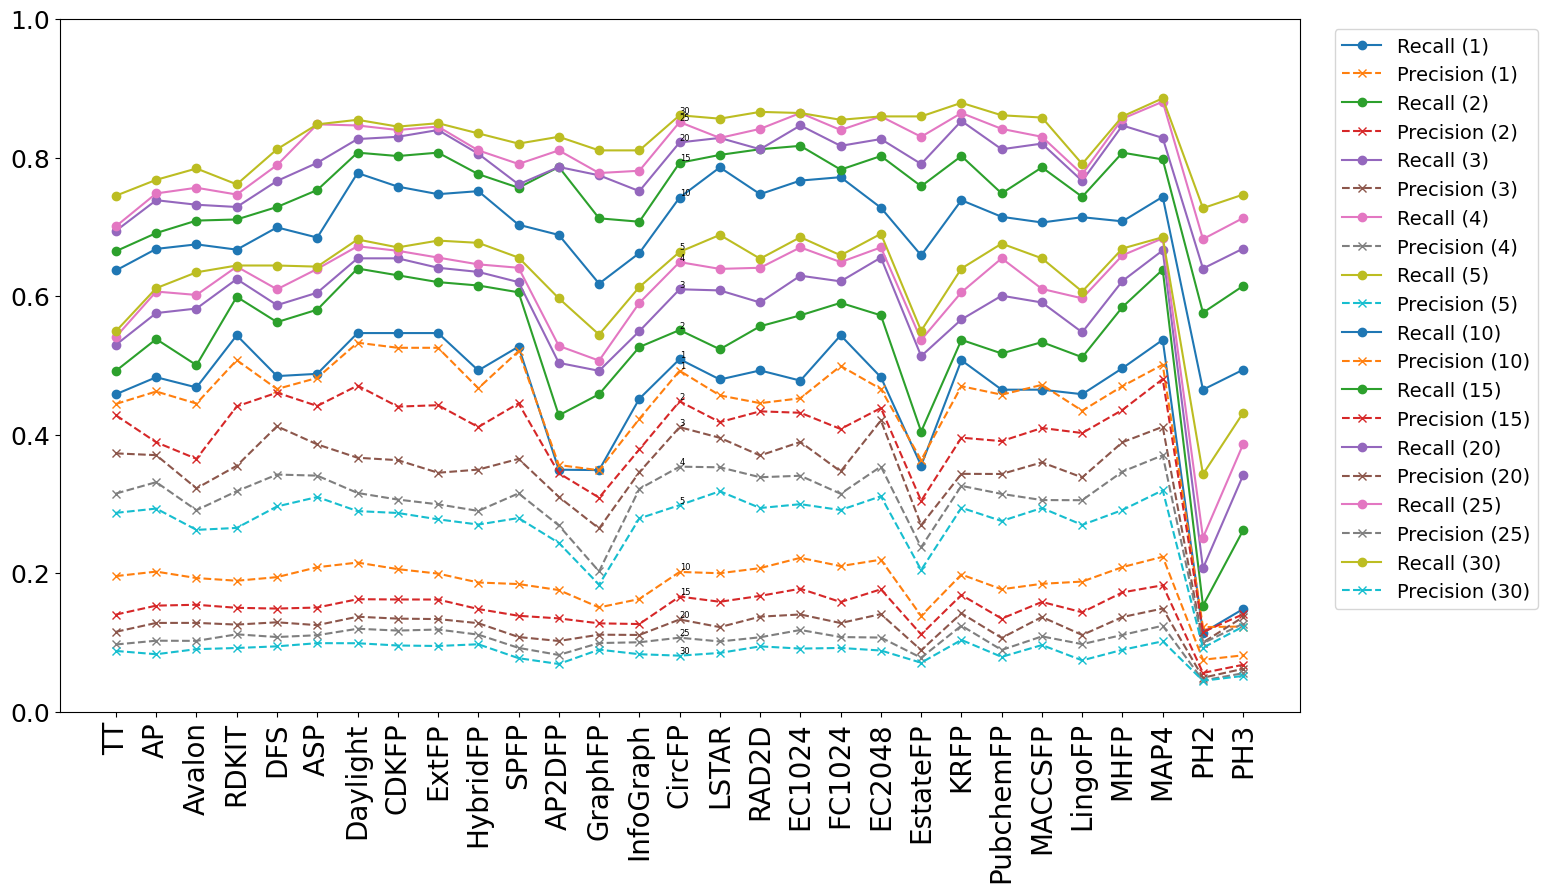

In [19]:
#Single-representation prediction

isea = pd.read_csv(f"{main_folder}/Data/Annotations/Isea_ATC.csv")
cmpd_annot = isea.rename(columns={'ATC class': 'annot', 'Name': 'cmpdname'}) #Rename 'ATC class' to 'annot' for second-level ATC task

fps = pd.read_csv(f"{main_folder}/Data/29FP_lst.csv")
fp_dict = {f:n for f,n in zip(fps['fp'], fps['name'])}

fp_lst = list(fp_dict.keys())
cc_dict = {}

for fp in fp_lst:
    cc_dict[fp] = pd.DataFrame()


for n in range(1,3):

    folder = f"{main_folder}/MSC_iSEA_Df/MSC_Isea_Sample_{n}"
    Sim_dfs = glob.glob(f"{folder}/*")
    df_dict = {}
    df_lst = []
    for f in Sim_dfs:
        f2 = f.replace(f'{folder}/','')
        name = f2.replace('.csv', '')

        temp = pd.read_csv(f)
        temp = temp.drop_duplicates('cid').reset_index(drop=True)

        temp = temp.reset_index(drop=True)
        temp['MSCs'] = temp['MSCs'].apply(json.loads)
        temp['similarities'] = temp['similarities'].apply(json.loads)

        df_dict[name] = temp
        df_lst.append(name)

    for fp in fp_lst:
        cc_dict[fp] = pd.concat([cc_dict[fp], df_dict[fp]])

for fp in fp_lst:
    cc_dict[fp] = cc_dict[fp].reset_index(drop=True)
        

plt.figure(figsize=(16, 9))

pred_dict = {}
rec_final = {}
prec_final = {}

for l in [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]:

    pred_dict[l] = {}
    length = l

    av_recall_dict = {}
    av_prec_dict = {}
    av_rank_dict = {}

    for k in fp_lst:
        final_df = []

        for i in cc_dict[k].index:
            pred_df = []

            q = cc_dict[k].loc[i, 'cid']

            for cid in cc_dict[k].loc[i, 'MSCs'][0:length]:
                cid_index = cc_dict[k].loc[i, 'MSCs'].index(cid)
                similarity = cc_dict[k].loc[i, 'similarities'][cid_index]

                preds = cmpd_annot[cmpd_annot['cid'] == cid].copy()
                preds = preds[['cid','cmpdname', 'annot']]
                preds['Sim'] = similarity
                pred_df.append(preds)

            final = pd.concat(pred_df).sort_values('Sim', ascending=False)
            final['test_cid'] = q

            final_df.append(final)

        pred_dict[l][k] = pd.concat(final_df).reset_index(drop=True)

    for k in fp_lst:
        final_pred = pred_dict[l][k]
        cmpds = final_pred['test_cid'].unique()

        recalls = []
        precs = []
        av_ranks = []

        for c in cmpds:
            df = final_pred[final_pred['test_cid'] == c]
            sim_com_lst = df.drop_duplicates('cid')['cid'].tolist()
            preds = df[df['cid'].isin(sim_com_lst[0:length])].drop_duplicates('annot', keep='first')['annot'].tolist()
            ans = cmpd_annot[cmpd_annot['cid'] == c]['annot'].tolist()

            score = 0
            ranks = []
            for p in preds:
                if p in ans:
                    score += 1
                    ranks.append(preds.index(p) + 1)

            if ranks:
                av_ranks.append(sum(ranks) / len(ranks))

            recalls.append(score / len(ans) if ans else 0)
            precs.append(score / len(preds) if preds else 0)

        av_recall_dict[k] = np.mean(recalls)
        av_prec_dict[k] = np.mean(precs)
        av_rank_dict[k] = np.mean(av_ranks)

    rec_final[l] = av_recall_dict
    prec_final[l] = av_prec_dict

#Plot

    x = []
    y_rec = []
    y_prec = []
    for k in list(fp_dict.keys()):
        x.append(fp_dict[k])
        y_rec.append(rec_final[l][k])
        y_prec.append(prec_final[l][k])

    plt.ylim(0.0, 1.0)

    plt.plot(x, y_rec, marker='o', label=f'Recall ({l})')
    plt.plot(x, y_prec, marker='x', linestyle='--', label=f'Precision ({l})')

    # Add text labels beside the lines
    mid_index = len(x) // 2
    plt.text(x[mid_index], y_rec[mid_index], f'{l}', fontsize=6, verticalalignment='bottom')
    plt.text(x[mid_index], y_prec[mid_index], f'{l}', fontsize=6, verticalalignment='bottom')


plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=18)
plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(1.2, 1))  # Adjust legend position)

plt.show()

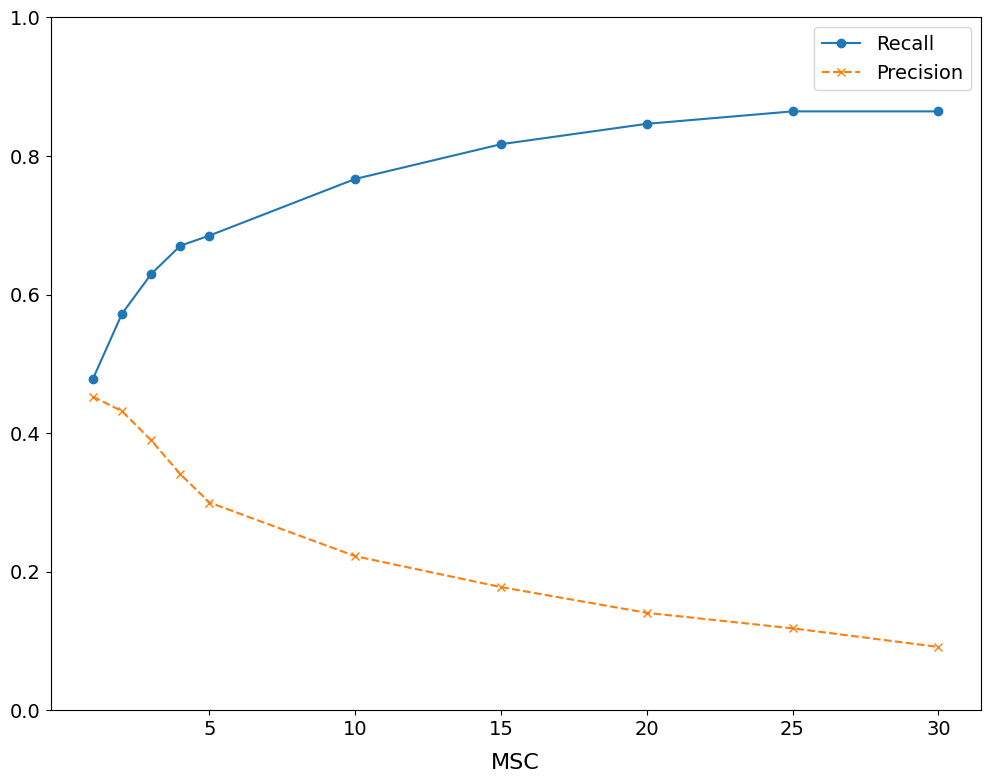

In [20]:
#Single-representation (Performace-MSC plot)

l_values = list(rec_final.keys())
rec_values = [np.mean(rec_final[l]['rdkitECFP']) for l in l_values]
prec_values = [np.mean(prec_final[l]['rdkitECFP']) for l in l_values]

# Plotting
plt.figure(figsize=(12, 9))
plt.ylim(0.0, 1.0)
plt.plot(l_values, rec_values, label='Recall', marker='o')
plt.plot(l_values, prec_values, label='Precision', marker='x', linestyle='--')
plt.xlabel('MSC', labelpad=10, fontsize=16)
plt.xticks(fontsize=14)
plt.xticks(np.arange(5, 31, 5))
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.show()

Using 22 representations: ['InfoGraphFeature', 'PubchemFP', 'jmapLSTAR', 'jmapDFS', 'ExtFP', 'minhashMAP4', 'jmapRAD2D', 'rdkitAvalon', 'rdkitRDKIT', 'HybridFP', 'KRFP', 'AP2DFP', 'SPFP', 'rdkitFCFP', 'rdkitECFP', 'jmapPH3', 'rdkitAP', 'maccsFP', 'GraphFP', 'LingoFP', 'EStateFP', 'CircFP']


100%|██████████| 2/2 [02:27<00:00, 73.70s/it]


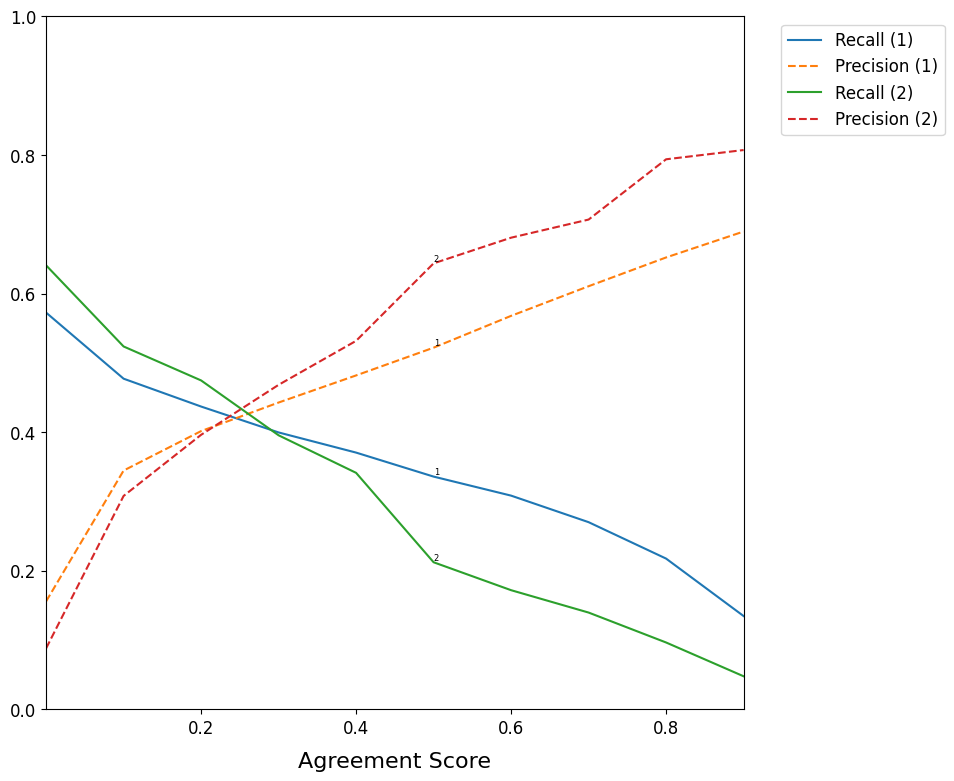

In [ ]:
#AgreementPred prediction (22 representations)

isea = pd.read_csv(f"{main_folder}/Data/Annotations/Isea_ATC.csv")
cmpd_annot = isea.rename(columns={'ATC4': 'annot', 'Name': 'cmpdname'}) #Rename 'ATC class' to 'annot' for second-level ATC task

fps = pd.read_csv(f"{main_folder}/Data/29FP_lst.csv")
fp_dict = {f:n for f,n in zip(fps['fp'], fps['name'])}

fp_lst = list(fp_dict.keys())
cc_dict = {}

for fp in fp_lst:
    cc_dict[fp] = pd.DataFrame()


for n in range(1,23):

    folder = f"{main_folder}/MSC_iSEA_Df/MSC_Isea_Sample_{n}"
    Sim_dfs = glob.glob(f"{folder}/*")
    df_dict = {}
    df_lst = []
    for f in Sim_dfs:
        f2 = f.replace(f'{folder}/','')
        name = f2.replace('.csv', '')

        temp = pd.read_csv(f)
        temp = temp.drop_duplicates('cid').reset_index(drop=True)

        temp = temp.reset_index(drop=True)
        temp['MSCs'] = temp['MSCs'].apply(json.loads)
        temp['similarities'] = temp['similarities'].apply(json.loads)

        df_dict[name] = temp
        df_lst.append(name)

    for fp in fp_lst:
        cc_dict[fp] = pd.concat([cc_dict[fp], df_dict[fp]])

for fp in fp_lst:
    cc_dict[fp] = cc_dict[fp].reset_index(drop=True)
        

plt.figure(figsize=(9, 9))

#Selected representations

fp_lst = list(fp_dict.keys())
fp_lst = list(set(fp_lst)-set(['rdkitTT','jmapASP', 'cdkDaylight', 'cdkFP', 'MorganFP', 'minhashMHFP', 'jmapPH2']))
fp_num = len(fp_lst)

print(f"Using {fp_num} representations: {fp_lst}")

for com_num in tqdm([1, 2]): 
    length = com_num

    pred_res = []
    all_preds = []

    for tcid in cc_dict[df_lst[0]]['cid'].unique():

        row = {'test_cid': tcid,
            'cmpdname': cmpd_annot.loc[cmpd_annot[cmpd_annot['cid']==tcid].index[0], 'cmpdname']}

        ans = cmpd_annot[cmpd_annot['cid']==tcid]['annot'].tolist()

        sel = []
        sim = []
        for name in fp_lst:

            sim_coms = cc_dict[name]
            sim_coms = sim_coms[['cid', 'cmpdname', 'MSCs', 'similarities']]
            
            com_lst = sim_coms.loc[sim_coms['cid'] == tcid, 'MSCs'].values[0]
            sim_lst = sim_coms.loc[sim_coms['cid'] == tcid, 'similarities'].values[0]

            sel.extend(com_lst[:length])
            sim.extend(sim_lst[:length])

        row['compound_num'] = len(set(sel))


        pred_df = pd.DataFrame()
        for com in sel:
            t1 = cmpd_annot[cmpd_annot['cid']==com]
            pred_df = pd.concat([pred_df, t1])

        pred = pred_df['annot'].value_counts().index.tolist()

        sig_scores = []
        for pre in pred:
            cnt = pred_df['annot'].value_counts()[pre]
            agree_score = cnt / (fp_num*length)
            if agree_score > 1:
                agree_score = 1
                
            r = {
                'test_cid': tcid,
                'cmpdname': cmpd_annot.loc[cmpd_annot[cmpd_annot['cid']==tcid].index[0], 'cmpdname'],
                'prediction': pre,
                'agreement score': agree_score,
                'result': 'Correct' if pre in ans else 'Incorrect'
            }
            all_preds.append(r)
            sig_scores.append(agree_score)

        correct = list(set(pred).intersection(set(ans)))

        row['score'] = len(correct)
        row['ans_num'] = len(ans)
        row['pred_num'] = len(set(pred))
        row['correct_ans'] = str(correct)

        if correct:
            ranks = [pred.index(c) + 1 for c in correct]
            row['av_rank'] = np.mean(ranks)
        else:
            row['av_rank'] = np.nan

        pred_res.append(row)

    pred_res_df = pd.DataFrame(pred_res)
    all_preds_df = pd.DataFrame(all_preds)

    pred_res_df.to_csv(f"{main_folder}/Results/Isea_pred_results_{com_num}MSCs.csv")
    all_preds_df.to_csv(f"{main_folder}/Results/Isea_all_preds_{com_num}MSCs.csv")


    tresh = []
    abs_recall = []
    abs_precision = []
    av_recall = []
    std_recall = []
    av_precision = []
    std_precision = []
    av_ranks = []
    std_ranks = []

    for i in [x * 0.1 for x in range(0, 10)]:

        pred_res_tr = pd.DataFrame()

        for cid in all_preds_df['test_cid'].unique():

            tdf = all_preds_df[(all_preds_df['test_cid'] == cid) & (all_preds_df['agreement score'] > i)]
            tdf = tdf.sort_values('agreement score', ascending=False)

            ans = cmpd_annot[cmpd_annot['cid'] == cid]['annot'].tolist()
            pred = tdf['prediction'].tolist()

            correct = list(set(pred).intersection(set(ans)))

            row = pred_res_tr.shape[0]
            
            pred_res_tr.loc[row, 'test_cid'] = cid
            pred_res_tr.loc[row, 'cmpdname'] = cmpd_annot.loc[cmpd_annot[cmpd_annot['cid'] == cid].index[0], 'cmpdname']

            pred_res_tr.loc[row, 'score'] = len(correct)
            pred_res_tr.loc[row, 'ans_num'] = len(ans)
            pred_res_tr.loc[row, 'pred_num'] = len(set(pred))
            pred_res_tr.loc[row, 'correct_ans'] = str(correct)

            if len(correct) > 0:
                ranks = []
                for c in correct:
                    rank = pred.index(c) + 1
                    ranks.append(rank)
            
                av_rank = np.mean(ranks)
                pred_res_tr.loc[row, 'av_rank'] = av_rank

            else:
                pred_res_tr.loc[row, 'av_rank'] = np.nan

        tresh.append(i)

        if sum(pred_res_tr['ans_num']) > 0:
            abs_recall.append(sum(pred_res_tr['score']) / sum(pred_res_tr['ans_num']))
        else:
            abs_recall.append(np.nan)

        if sum(pred_res_tr['pred_num']) > 0:
            abs_precision.append(sum(pred_res_tr['score']) / sum(pred_res_tr['pred_num']))
        else:
            abs_precision.append(np.nan)

        av_recall.append(np.mean(pred_res_tr['score'] / pred_res_tr['ans_num']) if sum(pred_res_tr['ans_num']) > 0 else np.nan)
        std_recall.append(np.std(pred_res_tr['score'] / pred_res_tr['ans_num']) if sum(pred_res_tr['ans_num']) > 0 else np.nan)
        av_precision.append(np.mean(pred_res_tr['score'] / pred_res_tr['pred_num']) if sum(pred_res_tr['pred_num']) > 0 else np.nan)
        std_precision.append(np.std(pred_res_tr['score'] / pred_res_tr['pred_num']) if sum(pred_res_tr['pred_num']) > 0 else np.nan)
        av_ranks.append(np.mean(pred_res_tr['av_rank']))
        std_ranks.append(np.std(pred_res_tr['av_rank']))


    tresh_table = {'tresh': tresh, 'abs_recall': abs_recall, 'abs_precision': abs_precision, 'av_recall': av_recall, 
                            'std_recall': std_recall, 'av_precision': av_precision, 'std_precision': std_precision, 'av_rank': av_ranks, 'std_rank': std_ranks}
    
    
    pd.DataFrame(tresh_table).to_csv(f"{main_folder}/Results/Isea_Treshold_results_{com_num}MSC.csv")

    X = tresh_table['tresh']

    plt.ylim(0.0, 1.0)
    plt.xlim(0.0, 0.9)
    plt.plot(X, tresh_table['av_recall'], label=f'Recall ({com_num})')
    plt.plot(X, tresh_table['av_precision'], linestyle='--', label=f'Precision ({com_num})')

    mid_index = len(X) // 2
    plt.text(X[mid_index], tresh_table['av_recall'][mid_index], f'{com_num}', fontsize=6, verticalalignment='bottom')
    plt.text(X[mid_index], tresh_table['av_precision'][mid_index], f'{com_num}', fontsize=6, verticalalignment='bottom')


plt.xlabel('Agreement Score', fontsize=16, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.xticks(np.arange(0.2, 1.0, 0.2))


plt.show()

For SIDER dataset

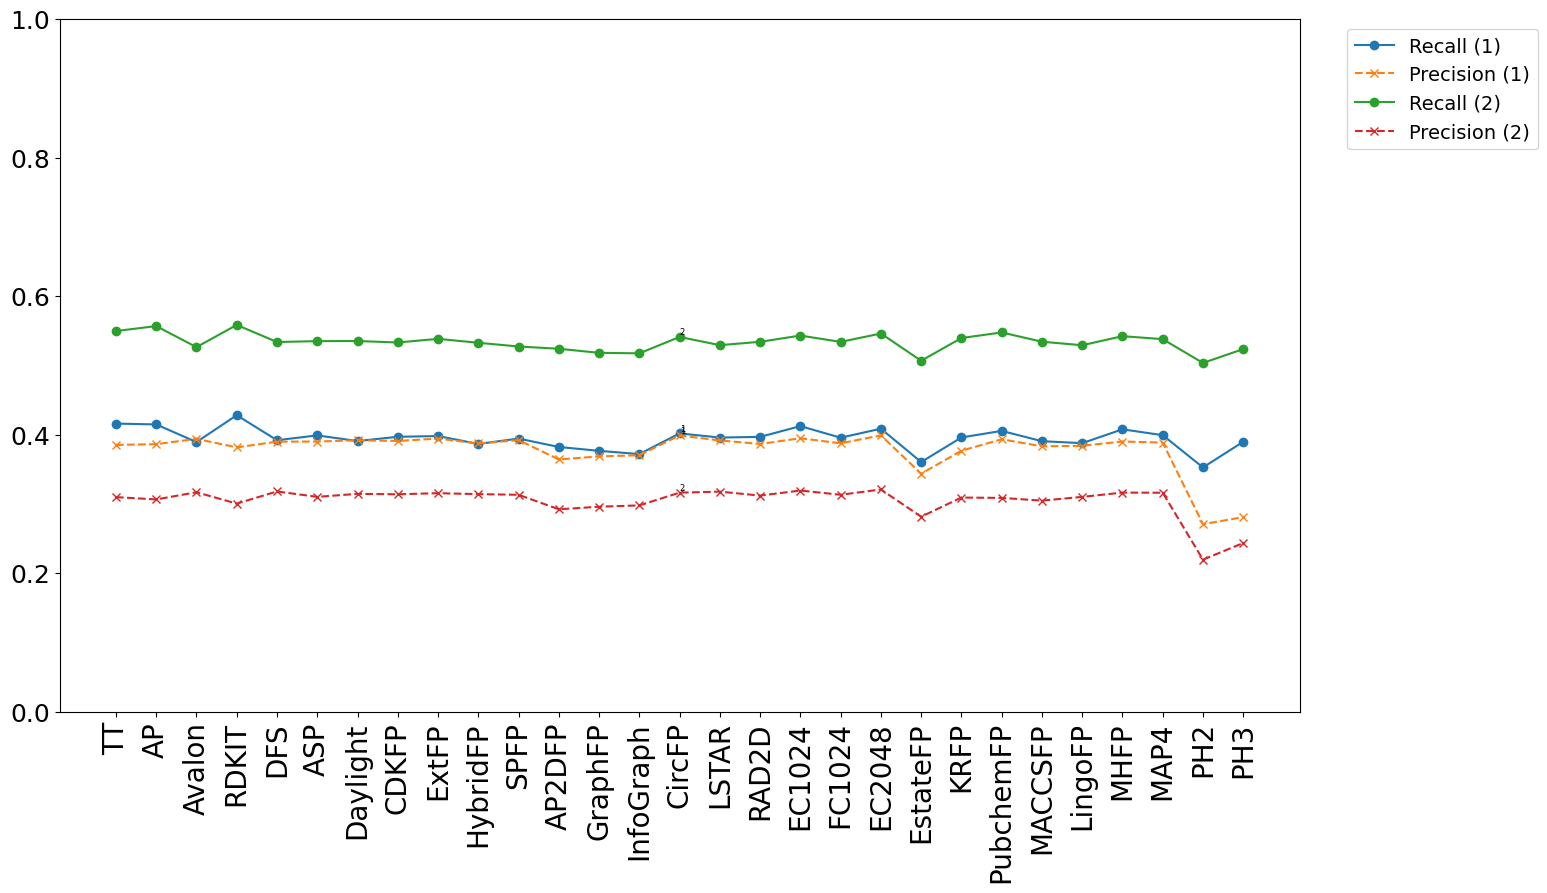

In [ ]:
#Single-representation prediction

sider = pd.read_csv(f"{main_folder}/Data/Annotations/Annotated-SE_Annotations.csv")
cmpd_annot = sider.rename(columns={'se':'annot'})

fps = pd.read_csv(f"{main_folder}/Data/29FP_lst.csv")
fp_dict = {f:n for f,n in zip(fps['fp'], fps['name'])}

fp_lst = list(fp_dict.keys())
cc_dict = {}

for fp in fp_lst:
    cc_dict[fp] = pd.DataFrame()


for n in range(1,2):

    folder = f"{main_folder}/MSC_SIDER_Df"
    Sim_dfs = glob.glob(f"{folder}/*")
    df_dict = {}
    df_lst = []
    for f in Sim_dfs:
        f2 = f.replace(f'{folder}/','')
        name = f2.replace('.csv', '')

        temp = pd.read_csv(f)
        temp = temp.drop_duplicates('cid').reset_index(drop=True)

        temp = temp.reset_index(drop=True)
        temp['MSCs'] = temp['MSCs'].apply(json.loads)
        temp['similarities'] = temp['similarities'].apply(json.loads)

        df_dict[name] = temp
        df_lst.append(name)

    for fp in fp_lst:
        cc_dict[fp] = pd.concat([cc_dict[fp], df_dict[fp]])

for fp in fp_lst:
    cc_dict[fp] = cc_dict[fp].reset_index(drop=True)
        

plt.figure(figsize=(16, 9))

pred_dict = {}
rec_final = {}
prec_final = {}

for l in [1, 2]:

    pred_dict[l] = {}
    length = l

    av_recall_dict = {}
    av_prec_dict = {}
    av_rank_dict = {}

    for k in fp_lst:
        final_df = []

        for i in cc_dict[k].index:
            pred_df = []

            q = cc_dict[k].loc[i, 'cid']

            for cid in cc_dict[k].loc[i, 'MSCs'][0:length]:
                cid_index = cc_dict[k].loc[i, 'MSCs'].index(cid)
                similarity = cc_dict[k].loc[i, 'similarities'][cid_index]

                preds = cmpd_annot[cmpd_annot['cid'] == cid].copy()
                preds = preds[['cid','cmpdname', 'annot']]
                preds['Sim'] = similarity
                pred_df.append(preds)

            final = pd.concat(pred_df).sort_values('Sim', ascending=False)
            final['test_cid'] = q

            final_df.append(final)

        pred_dict[l][k] = pd.concat(final_df).reset_index(drop=True)

    for k in fp_lst:
        final_pred = pred_dict[l][k]
        cmpds = final_pred['test_cid'].unique()

        recalls = []
        precs = []
        av_ranks = []

        for c in cmpds:
            df = final_pred[final_pred['test_cid'] == c]
            sim_com_lst = df.drop_duplicates('cid')['cid'].tolist()
            preds = df[df['cid'].isin(sim_com_lst[0:length])].drop_duplicates('annot', keep='first')['annot'].tolist()
            ans = cmpd_annot[cmpd_annot['cid'] == c]['annot'].tolist()

            score = 0
            ranks = []
            for p in preds:
                if p in ans:
                    score += 1
                    ranks.append(preds.index(p) + 1)

            if ranks:
                av_ranks.append(sum(ranks) / len(ranks))

            recalls.append(score / len(ans) if ans else 0)
            precs.append(score / len(preds) if preds else 0)

        av_recall_dict[k] = np.mean(recalls)
        av_prec_dict[k] = np.mean(precs)
        av_rank_dict[k] = np.mean(av_ranks)

    rec_final[l] = av_recall_dict
    prec_final[l] = av_prec_dict

#Plot

    x = []
    y_rec = []
    y_prec = []
    for k in list(fp_dict.keys()):
        x.append(fp_dict[k])
        y_rec.append(rec_final[l][k])
        y_prec.append(prec_final[l][k])

    plt.ylim(0.0, 1.0)

    plt.plot(x, y_rec, marker='o', label=f'Recall ({l})')
    plt.plot(x, y_prec, marker='x', linestyle='--', label=f'Precision ({l})')

    # Add text labels beside the lines
    mid_index = len(x) // 2
    plt.text(x[mid_index], y_rec[mid_index], f'{l}', fontsize=6, verticalalignment='bottom')
    plt.text(x[mid_index], y_prec[mid_index], f'{l}', fontsize=6, verticalalignment='bottom')


plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=18)
plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(1.2, 1))  # Adjust legend position)

plt.show()

Using 22 representations: ['InfoGraphFeature', 'PubchemFP', 'jmapLSTAR', 'jmapDFS', 'ExtFP', 'minhashMAP4', 'jmapRAD2D', 'rdkitAvalon', 'rdkitRDKIT', 'HybridFP', 'KRFP', 'AP2DFP', 'SPFP', 'rdkitFCFP', 'rdkitECFP', 'jmapPH3', 'rdkitAP', 'maccsFP', 'GraphFP', 'LingoFP', 'EStateFP', 'CircFP']


100%|██████████| 2/2 [29:11<00:00, 875.73s/it]


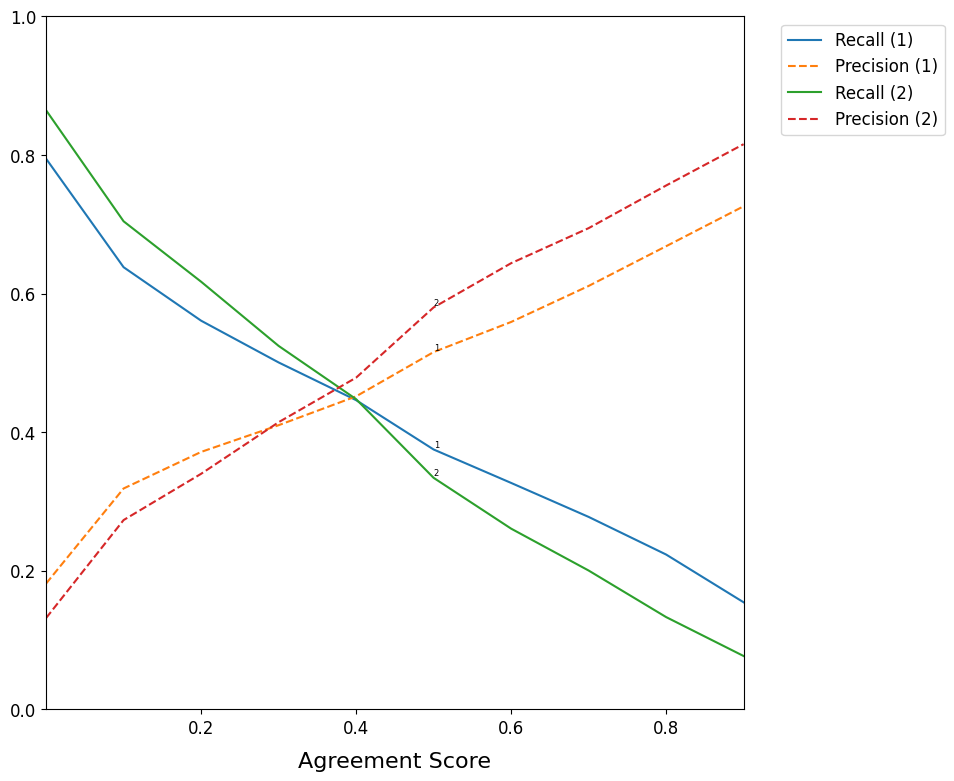

In [ ]:
#AgreementPred prediction (22 representations)

sider = pd.read_csv(f"{main_folder}/Data/Annotations/Annotated-SE_Annotations.csv")
cmpd_annot = sider.rename(columns={'se':'annot'})

fps = pd.read_csv(f"{main_folder}/Data/29FP_lst.csv")
fp_dict = {f:n for f,n in zip(fps['fp'], fps['name'])}

fp_lst = list(fp_dict.keys())
cc_dict = {}

for fp in fp_lst:
    cc_dict[fp] = pd.DataFrame()


for n in range(1,2):

    folder = f"{main_folder}/MSC_SIDER_Df"
    Sim_dfs = glob.glob(f"{folder}/*")
    df_dict = {}
    df_lst = []
    for f in Sim_dfs:
        f2 = f.replace(f'{folder}/','')
        name = f2.replace('.csv', '')

        temp = pd.read_csv(f)
        temp = temp.drop_duplicates('cid').reset_index(drop=True)

        temp = temp.reset_index(drop=True)
        temp['MSCs'] = temp['MSCs'].apply(json.loads)
        temp['similarities'] = temp['similarities'].apply(json.loads)

        df_dict[name] = temp
        df_lst.append(name)

    for fp in fp_lst:
        cc_dict[fp] = pd.concat([cc_dict[fp], df_dict[fp]])

for fp in fp_lst:
    cc_dict[fp] = cc_dict[fp].reset_index(drop=True)
        

plt.figure(figsize=(9, 9))
#Selected representations

fp_lst = list(fp_dict.keys())
fp_lst = list(set(fp_lst)-set(['rdkitTT','jmapASP', 'cdkDaylight', 'cdkFP', 'MorganFP', 'minhashMHFP', 'jmapPH2']))
fp_num = len(fp_lst)

print(f"Using {fp_num} representations: {fp_lst}")

for com_num in tqdm([1, 2]): 
    length = com_num

    pred_res = []
    all_preds = []

    for tcid in cc_dict[df_lst[0]]['cid'].unique():

        row = {'test_cid': tcid,
            'cmpdname': cmpd_annot.loc[cmpd_annot[cmpd_annot['cid']==tcid].index[0], 'cmpdname']}

        ans = cmpd_annot[cmpd_annot['cid']==tcid]['annot'].tolist()

        sel = []
        sim = []
        for name in fp_lst:

            sim_coms = cc_dict[name]
            sim_coms = sim_coms[['cid', 'cmpdname', 'MSCs', 'similarities']]
            
            com_lst = sim_coms.loc[sim_coms['cid'] == tcid, 'MSCs'].values[0]
            sim_lst = sim_coms.loc[sim_coms['cid'] == tcid, 'similarities'].values[0]

            sel.extend(com_lst[:length])
            sim.extend(sim_lst[:length])

        row['compound_num'] = len(set(sel))


        pred_df = pd.DataFrame()
        for com in sel:
            t1 = cmpd_annot[cmpd_annot['cid']==com]
            pred_df = pd.concat([pred_df, t1])

        pred = pred_df['annot'].value_counts().index.tolist()

        sig_scores = []
        for pre in pred:
            cnt = pred_df['annot'].value_counts()[pre]
            agree_score = cnt / (fp_num*length)
            if agree_score > 1:
                agree_score = 1
                
            r = {
                'test_cid': tcid,
                'cmpdname': cmpd_annot.loc[cmpd_annot[cmpd_annot['cid']==tcid].index[0], 'cmpdname'],
                'prediction': pre,
                'agreement score': agree_score,
                'result': 'Correct' if pre in ans else 'Incorrect'
            }
            all_preds.append(r)
            sig_scores.append(agree_score)

        correct = list(set(pred).intersection(set(ans)))

        row['score'] = len(correct)
        row['ans_num'] = len(ans)
        row['pred_num'] = len(set(pred))
        row['correct_ans'] = str(correct)

        if correct:
            ranks = [pred.index(c) + 1 for c in correct]
            row['av_rank'] = np.mean(ranks)
        else:
            row['av_rank'] = np.nan

        pred_res.append(row)

    pred_res_df = pd.DataFrame(pred_res)
    all_preds_df = pd.DataFrame(all_preds)

    pred_res_df.to_csv(f"{main_folder}/Results/SIDER_pred_results_{com_num}MSCs.csv")
    all_preds_df.to_csv(f"{main_folder}/Results/SIDER_all_preds_{com_num}MSCs.csv")


    tresh = []
    abs_recall = []
    abs_precision = []
    av_recall = []
    std_recall = []
    av_precision = []
    std_precision = []
    av_ranks = []
    std_ranks = []

    for i in [x * 0.1 for x in range(0, 10)]:

        pred_res_tr = pd.DataFrame()

        for cid in all_preds_df['test_cid'].unique():

            tdf = all_preds_df[(all_preds_df['test_cid'] == cid) & (all_preds_df['agreement score'] > i)]
            tdf = tdf.sort_values('agreement score', ascending=False)

            ans = cmpd_annot[cmpd_annot['cid'] == cid]['annot'].tolist()
            pred = tdf['prediction'].tolist()

            correct = list(set(pred).intersection(set(ans)))

            row = pred_res_tr.shape[0]
            
            pred_res_tr.loc[row, 'test_cid'] = cid
            pred_res_tr.loc[row, 'cmpdname'] = cmpd_annot.loc[cmpd_annot[cmpd_annot['cid'] == cid].index[0], 'cmpdname']

            pred_res_tr.loc[row, 'score'] = len(correct)
            pred_res_tr.loc[row, 'ans_num'] = len(ans)
            pred_res_tr.loc[row, 'pred_num'] = len(set(pred))
            pred_res_tr.loc[row, 'correct_ans'] = str(correct)

            if len(correct) > 0:
                ranks = []
                for c in correct:
                    rank = pred.index(c) + 1
                    ranks.append(rank)
            
                av_rank = np.mean(ranks)
                pred_res_tr.loc[row, 'av_rank'] = av_rank

            else:
                pred_res_tr.loc[row, 'av_rank'] = np.nan

        tresh.append(i)

        if sum(pred_res_tr['ans_num']) > 0:
            abs_recall.append(sum(pred_res_tr['score']) / sum(pred_res_tr['ans_num']))
        else:
            abs_recall.append(np.nan)

        if sum(pred_res_tr['pred_num']) > 0:
            abs_precision.append(sum(pred_res_tr['score']) / sum(pred_res_tr['pred_num']))
        else:
            abs_precision.append(np.nan)

        av_recall.append(np.mean(pred_res_tr['score'] / pred_res_tr['ans_num']) if sum(pred_res_tr['ans_num']) > 0 else np.nan)
        std_recall.append(np.std(pred_res_tr['score'] / pred_res_tr['ans_num']) if sum(pred_res_tr['ans_num']) > 0 else np.nan)
        av_precision.append(np.mean(pred_res_tr['score'] / pred_res_tr['pred_num']) if sum(pred_res_tr['pred_num']) > 0 else np.nan)
        std_precision.append(np.std(pred_res_tr['score'] / pred_res_tr['pred_num']) if sum(pred_res_tr['pred_num']) > 0 else np.nan)
        av_ranks.append(np.mean(pred_res_tr['av_rank']))
        std_ranks.append(np.std(pred_res_tr['av_rank']))


    tresh_table = {'tresh': tresh, 'abs_recall': abs_recall, 'abs_precision': abs_precision, 'av_recall': av_recall, 
                            'std_recall': std_recall, 'av_precision': av_precision, 'std_precision': std_precision, 'av_rank': av_ranks, 'std_rank': std_ranks}
    
    
    pd.DataFrame(tresh_table).to_csv(f"{main_folder}/Results/SIDER_Treshold_results_{com_num}MSC.csv")

    X = tresh_table['tresh']

    plt.ylim(0.0, 1.0)
    plt.xlim(0.0, 0.9)
    plt.plot(X, tresh_table['av_recall'], label=f'Recall ({com_num})')
    plt.plot(X, tresh_table['av_precision'], linestyle='--', label=f'Precision ({com_num})')

    mid_index = len(X) // 2
    plt.text(X[mid_index], tresh_table['av_recall'][mid_index], f'{com_num}', fontsize=6, verticalalignment='bottom')
    plt.text(X[mid_index], tresh_table['av_precision'][mid_index], f'{com_num}', fontsize=6, verticalalignment='bottom')


plt.xlabel('Agreement Score', fontsize=16, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.xticks(np.arange(0.2, 1.0, 0.2))


plt.show()

For Annotated-Compounds sample datasets. 

Change the testset_name to evaluate on different sample datasets (Annocom, Drug, and NP)

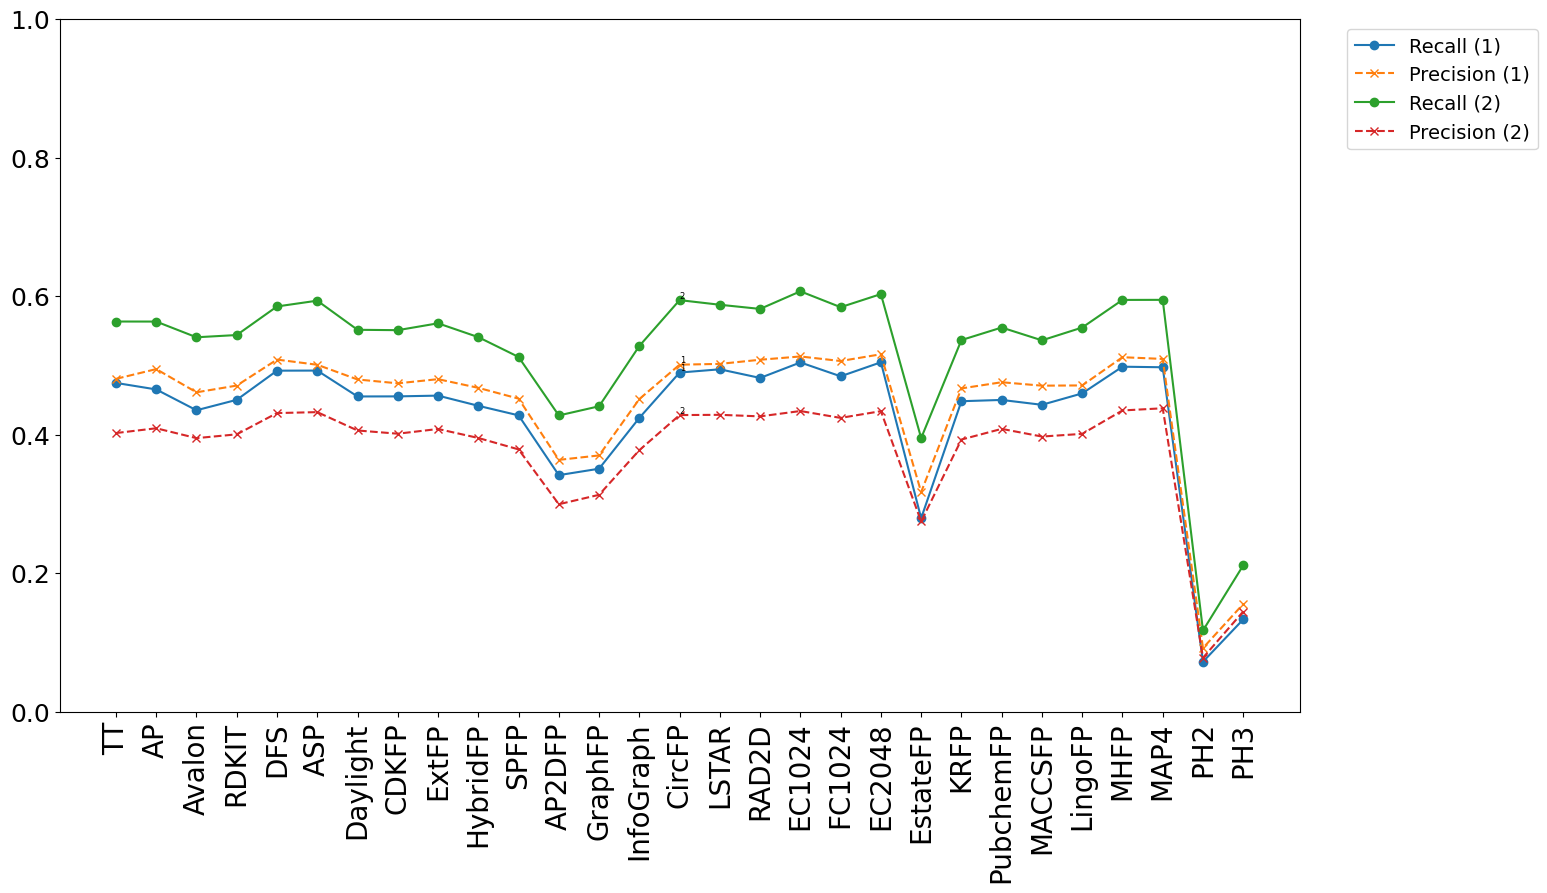

In [ ]:
#Single-representation prediction

cmpd_annot = pd.read_csv(f"{main_folder}/Data/Annotations/Annotated-Compound_Annotations.csv")

fps = pd.read_csv(f"{main_folder}/Data/29FP_lst.csv")
fp_dict = {f:n for f,n in zip(fps['fp'], fps['name'])}

fp_lst = list(fp_dict.keys())
cc_dict = {}

for fp in fp_lst:
    cc_dict[fp] = pd.DataFrame()

testset_name = "Drug" ###Testset name (Eg. Annocom, DrugBank, or NP)

for n in range(1,21):

    folder = f"{main_folder}/MSC_Df/MSC_{testset_name}_Sample_{n}"
    Sim_dfs = glob.glob(f"{folder}/*")
    df_dict = {}
    df_lst = []
    for f in Sim_dfs:
        f2 = f.replace(f'{folder}/','')
        name = f2.replace('.csv', '')

        temp = pd.read_csv(f)
        temp = temp.drop_duplicates('cid').reset_index(drop=True)

        temp = temp.reset_index(drop=True)
        temp['MSCs'] = temp['MSCs'].apply(json.loads)
        temp['similarities'] = temp['similarities'].apply(json.loads)

        df_dict[name] = temp
        df_lst.append(name)

    for fp in fp_lst:
        cc_dict[fp] = pd.concat([cc_dict[fp], df_dict[fp]])

for fp in fp_lst:
    cc_dict[fp] = cc_dict[fp].reset_index(drop=True)
        

plt.figure(figsize=(16, 9))

pred_dict = {}
rec_final = {}
prec_final = {}

for l in [1, 2]:

    pred_dict[l] = {}
    length = l

    av_recall_dict = {}
    av_prec_dict = {}
    av_rank_dict = {}

    for k in fp_lst:
        final_df = []

        for i in cc_dict[k].index:
            pred_df = []

            q = cc_dict[k].loc[i, 'cid']

            for cid in cc_dict[k].loc[i, 'MSCs'][0:length]:
                cid_index = cc_dict[k].loc[i, 'MSCs'].index(cid)
                similarity = cc_dict[k].loc[i, 'similarities'][cid_index]

                preds = cmpd_annot[cmpd_annot['cid'] == cid].copy()
                preds = preds[['cid','cmpdname', 'annot']]
                preds['Sim'] = similarity
                pred_df.append(preds)

            final = pd.concat(pred_df).sort_values('Sim', ascending=False)
            final['test_cid'] = q

            final_df.append(final)

        pred_dict[l][k] = pd.concat(final_df).reset_index(drop=True)

    for k in fp_lst:
        final_pred = pred_dict[l][k]
        cmpds = final_pred['test_cid'].unique()

        recalls = []
        precs = []
        av_ranks = []

        for c in cmpds:
            df = final_pred[final_pred['test_cid'] == c]
            sim_com_lst = df.drop_duplicates('cid')['cid'].tolist()
            preds = df[df['cid'].isin(sim_com_lst[0:length])].drop_duplicates('annot', keep='first')['annot'].tolist()
            ans = cmpd_annot[cmpd_annot['cid'] == c]['annot'].tolist()

            score = 0
            ranks = []
            for p in preds:
                if p in ans:
                    score += 1
                    ranks.append(preds.index(p) + 1)

            if ranks:
                av_ranks.append(sum(ranks) / len(ranks))

            recalls.append(score / len(ans) if ans else 0)
            precs.append(score / len(preds) if preds else 0)

        av_recall_dict[k] = np.mean(recalls)
        av_prec_dict[k] = np.mean(precs)
        av_rank_dict[k] = np.mean(av_ranks)

    rec_final[l] = av_recall_dict
    prec_final[l] = av_prec_dict

#Plot

    x = []
    y_rec = []
    y_prec = []
    for k in list(fp_dict.keys()):
        x.append(fp_dict[k])
        y_rec.append(rec_final[l][k])
        y_prec.append(prec_final[l][k])

    plt.ylim(0.0, 1.0)

    plt.plot(x, y_rec, marker='o', label=f'Recall ({l})')
    plt.plot(x, y_prec, marker='x', linestyle='--', label=f'Precision ({l})')

    # Add text labels beside the lines
    mid_index = len(x) // 2
    plt.text(x[mid_index], y_rec[mid_index], f'{l}', fontsize=6, verticalalignment='bottom')
    plt.text(x[mid_index], y_prec[mid_index], f'{l}', fontsize=6, verticalalignment='bottom')


plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=18)
plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(1.2, 1))  # Adjust legend position)

plt.show()

Using 22 representations: ['InfoGraphFeature', 'PubchemFP', 'jmapLSTAR', 'jmapDFS', 'ExtFP', 'minhashMAP4', 'jmapRAD2D', 'rdkitAvalon', 'rdkitRDKIT', 'HybridFP', 'KRFP', 'AP2DFP', 'SPFP', 'rdkitFCFP', 'rdkitECFP', 'jmapPH3', 'rdkitAP', 'maccsFP', 'GraphFP', 'LingoFP', 'EStateFP', 'CircFP']


100%|██████████| 2/2 [02:30<00:00, 75.07s/it]


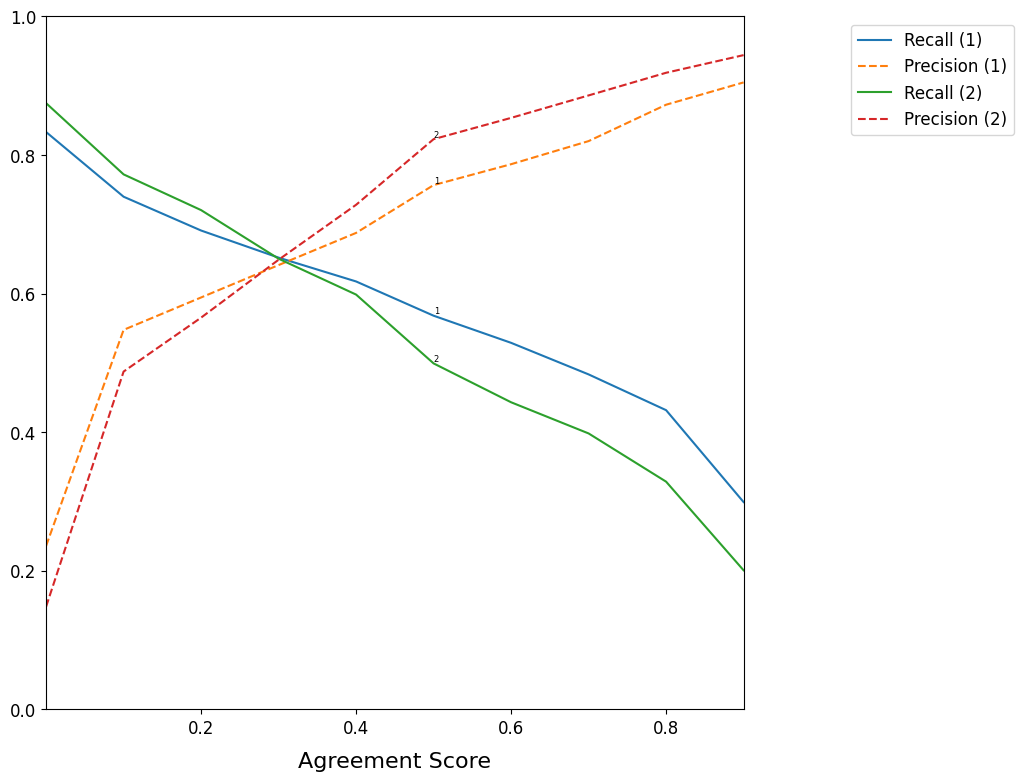

In [ ]:
#AgreementPred prediction (22 representations)

cmpd_annot = pd.read_csv(f"{main_folder}/Data/Annotations/Annotated-Compound_Annotations.csv")


fps = pd.read_csv(f"{main_folder}/Data/29FP_lst.csv")
fp_dict = {f:n for f,n in zip(fps['fp'], fps['name'])}

fp_lst = list(fp_dict.keys())
cc_dict = {}

for fp in fp_lst:
    cc_dict[fp] = pd.DataFrame()

testset_name = "Annocom" ###Testset name (Eg. Annocom, DrugBank, or NP)

for n in range(1,21):

    folder = f"{main_folder}/MSC_Df/MSC_{testset_name}_Sample_{n}"
    Sim_dfs = glob.glob(f"{folder}/*")
    df_dict = {}
    df_lst = []
    for f in Sim_dfs:
        f2 = f.replace(f'{folder}/','')
        name = f2.replace('.csv', '')

        temp = pd.read_csv(f)
        temp = temp.drop_duplicates('cid').reset_index(drop=True)

        temp = temp.reset_index(drop=True)
        temp['MSCs'] = temp['MSCs'].apply(json.loads)
        temp['similarities'] = temp['similarities'].apply(json.loads)

        df_dict[name] = temp
        df_lst.append(name)

    for fp in fp_lst:
        cc_dict[fp] = pd.concat([cc_dict[fp], df_dict[fp]])

for fp in fp_lst:
    cc_dict[fp] = cc_dict[fp].reset_index(drop=True)
        

plt.figure(figsize=(9, 9))
#Selected representations

fp_lst = list(fp_dict.keys())
fp_lst = list(set(fp_lst)-set(['rdkitTT','jmapASP', 'cdkDaylight', 'cdkFP', 'MorganFP', 'minhashMHFP', 'jmapPH2']))
fp_num = len(fp_lst)

print(f"Using {fp_num} representations: {fp_lst}")

for com_num in tqdm([1, 2]): 
    length = com_num

    pred_res = []
    all_preds = []

    for tcid in cc_dict[df_lst[0]]['cid'].unique():

        row = {'test_cid': tcid,
            'cmpdname': cmpd_annot.loc[cmpd_annot[cmpd_annot['cid']==tcid].index[0], 'cmpdname']}

        ans = cmpd_annot[cmpd_annot['cid']==tcid]['annot'].tolist()

        sel = []
        sim = []
        for name in fp_lst:

            sim_coms = cc_dict[name]
            sim_coms = sim_coms[['cid', 'cmpdname', 'MSCs', 'similarities']]
            
            com_lst = sim_coms.loc[sim_coms['cid'] == tcid, 'MSCs'].values[0]
            sim_lst = sim_coms.loc[sim_coms['cid'] == tcid, 'similarities'].values[0]

            sel.extend(com_lst[:length])
            sim.extend(sim_lst[:length])

        row['compound_num'] = len(set(sel))


        pred_df = pd.DataFrame()
        for com in sel:
            t1 = cmpd_annot[cmpd_annot['cid']==com]
            pred_df = pd.concat([pred_df, t1])

        pred = pred_df['annot'].value_counts().index.tolist()

        sig_scores = []
        for pre in pred:
            cnt = pred_df['annot'].value_counts()[pre]
            agree_score = cnt / (fp_num*length)
            if agree_score > 1:
                agree_score = 1
                
            r = {
                'test_cid': tcid,
                'cmpdname': cmpd_annot.loc[cmpd_annot[cmpd_annot['cid']==tcid].index[0], 'cmpdname'],
                'prediction': pre,
                'agreement score': agree_score,
                'result': 'Correct' if pre in ans else 'Incorrect'
            }
            all_preds.append(r)
            sig_scores.append(agree_score)

        correct = list(set(pred).intersection(set(ans)))

        row['score'] = len(correct)
        row['ans_num'] = len(ans)
        row['pred_num'] = len(set(pred))
        row['correct_ans'] = str(correct)

        if correct:
            ranks = [pred.index(c) + 1 for c in correct]
            row['av_rank'] = np.mean(ranks)
        else:
            row['av_rank'] = np.nan

        pred_res.append(row)

    pred_res_df = pd.DataFrame(pred_res)
    all_preds_df = pd.DataFrame(all_preds)

    pred_res_df.to_csv(f"{main_folder}/Results/{testset_name}1000_pred_results_{com_num}MSCs.csv")
    all_preds_df.to_csv(f"{main_folder}/Results/{testset_name}1000_all_preds_{com_num}MSCs.csv")


    tresh = []
    abs_recall = []
    abs_precision = []
    av_recall = []
    std_recall = []
    av_precision = []
    std_precision = []
    av_ranks = []
    std_ranks = []

    for i in [x * 0.1 for x in range(0, 10)]:

        pred_res_tr = pd.DataFrame()

        for cid in all_preds_df['test_cid'].unique():

            tdf = all_preds_df[(all_preds_df['test_cid'] == cid) & (all_preds_df['agreement score'] > i)]
            tdf = tdf.sort_values('agreement score', ascending=False)

            ans = cmpd_annot[cmpd_annot['cid'] == cid]['annot'].tolist()
            pred = tdf['prediction'].tolist()

            correct = list(set(pred).intersection(set(ans)))

            row = pred_res_tr.shape[0]
            
            pred_res_tr.loc[row, 'test_cid'] = cid
            pred_res_tr.loc[row, 'cmpdname'] = cmpd_annot.loc[cmpd_annot[cmpd_annot['cid'] == cid].index[0], 'cmpdname']

            pred_res_tr.loc[row, 'score'] = len(correct)
            pred_res_tr.loc[row, 'ans_num'] = len(ans)
            pred_res_tr.loc[row, 'pred_num'] = len(set(pred))
            pred_res_tr.loc[row, 'correct_ans'] = str(correct)

            if len(correct) > 0:
                ranks = []
                for c in correct:
                    rank = pred.index(c) + 1
                    ranks.append(rank)
            
                av_rank = np.mean(ranks)
                pred_res_tr.loc[row, 'av_rank'] = av_rank

            else:
                pred_res_tr.loc[row, 'av_rank'] = np.nan

        tresh.append(i)

        if sum(pred_res_tr['ans_num']) > 0:
            abs_recall.append(sum(pred_res_tr['score']) / sum(pred_res_tr['ans_num']))
        else:
            abs_recall.append(np.nan)

        if sum(pred_res_tr['pred_num']) > 0:
            abs_precision.append(sum(pred_res_tr['score']) / sum(pred_res_tr['pred_num']))
        else:
            abs_precision.append(np.nan)

        av_recall.append(np.mean(pred_res_tr['score'] / pred_res_tr['ans_num']) if sum(pred_res_tr['ans_num']) > 0 else np.nan)
        std_recall.append(np.std(pred_res_tr['score'] / pred_res_tr['ans_num']) if sum(pred_res_tr['ans_num']) > 0 else np.nan)
        av_precision.append(np.mean(pred_res_tr['score'] / pred_res_tr['pred_num']) if sum(pred_res_tr['pred_num']) > 0 else np.nan)
        std_precision.append(np.std(pred_res_tr['score'] / pred_res_tr['pred_num']) if sum(pred_res_tr['pred_num']) > 0 else np.nan)
        av_ranks.append(np.mean(pred_res_tr['av_rank']))
        std_ranks.append(np.std(pred_res_tr['av_rank']))


    tresh_table = {'tresh': tresh, 'abs_recall': abs_recall, 'abs_precision': abs_precision, 'av_recall': av_recall, 
                            'std_recall': std_recall, 'av_precision': av_precision, 'std_precision': std_precision, 'av_rank': av_ranks, 'std_rank': std_ranks}
    
    
    pd.DataFrame(tresh_table).to_csv(f"{main_folder}/Results/{testset_name}1000_Treshold_results_{com_num}MSC.csv")

    X = tresh_table['tresh']

    plt.ylim(0.0, 1.0)
    plt.xlim(0.0, 0.9)
    plt.plot(X, tresh_table['av_recall'], label=f'Recall ({com_num})')
    plt.plot(X, tresh_table['av_precision'], linestyle='--', label=f'Precision ({com_num})')

    mid_index = len(X) // 2
    plt.text(X[mid_index], tresh_table['av_recall'][mid_index], f'{com_num}', fontsize=6, verticalalignment='bottom')
    plt.text(X[mid_index], tresh_table['av_precision'][mid_index], f'{com_num}', fontsize=6, verticalalignment='bottom')


plt.xlabel('Agreement Score', fontsize=16, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.xticks(np.arange(0.2, 1.0, 0.2))


plt.show()

SD-ATC implementation

100%|██████████| 2/2 [00:40<00:00, 20.45s/it]


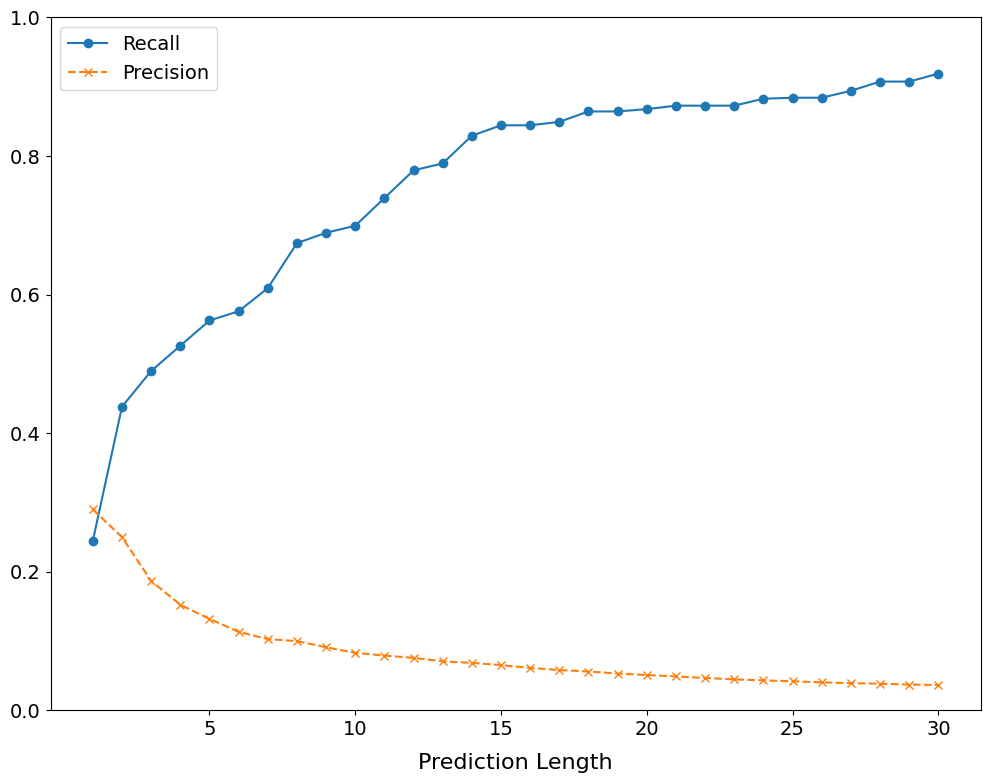

In [14]:
#Second-, forth-level ATC tasks

fpdf = pd.read_csv(f"{main_folder}/Data/Representations_Isea1157/KRFP.csv")
fpdf = fpdf.drop_duplicates('cid').reset_index(drop=True)

isea = pd.read_csv(f"{main_folder}/Data/Annotations/Isea_ATC.csv")
cmpd_annot = isea.rename(columns={'ATC class': 'annot', 'Name': 'cmpdname'}) #Rename 'ATC class' to 'annot' for second-level ATC task
cmpd_annot = cmpd_annot[(cmpd_annot['Category']=='approved_drugs') & (cmpd_annot['cid'].isin(fpdf['cid'].tolist()))].reset_index(drop=True)

all_results = []

folder = f"{main_folder}/Data/Sample_datasets/Isea_Testset"
file_list = glob.glob(f"{folder}/*")

cids = fpdf['cid']
atcs = cmpd_annot['annot'].unique()

Mds = fpdf.loc[:, 'KRFP_1':'KRFP_4860']
Mds.index = fpdf['cid']

for f in tqdm(file_list[0:2]):
    testset = pd.read_csv(f)
    test_cids = testset['cid'].tolist()

    Mda = pd.DataFrame(0, index=cids, columns=atcs)

    train_cids = fpdf[~fpdf['cid'].isin(testset['cid'].tolist())]['cid'].tolist()

    for id in train_cids:
        try:
            drug_atcs = cmpd_annot[cmpd_annot['cid']==id]['annot'].tolist()
            for a in drug_atcs:
                Mda.loc[id, a] = 1
        except:
            pass

    c1 = np.vstack((np.zeros((Mda.shape[0], Mda.shape[0])), np.array(Mds.T), np.array(Mda.T)))
    c2 = np.vstack((np.array(Mds), np.zeros((Mds.shape[1]+Mda.shape[1], Mds.shape[1]))))
    c3 = np.vstack((np.array(Mda), np.zeros((Mds.shape[1]+Mda.shape[1], Mda.shape[1]))))
    w1 = np.hstack((c1, c2, c3))
    r1 = w1.copy()
    for i in range(0, w1.shape[0]):
        denom = sum(w1[i])
        for j in range(0, w1.shape[1]):
            if denom != 0:
                new = w1[i,j]/denom
                r1[i,j] = new
            
            else:
                r1[i,j] = 0
  
    r1k2 = np.linalg.matrix_power(r1, 2)
    y1 = np.matmul(w1, r1k2)
    DA_pred = Mda.copy()

    for i in range(0, len(Mda.index)):
        for j in range(0, len(Mda.columns)):
            DA_pred.iloc[i,j] = y1[i, (Mds.shape[0]+Mds.shape[1])+j]

    DA_pred = DA_pred.loc[test_cids,:]
    DA_pred = DA_pred.T

    results = pd.DataFrame()

    for l in range(1, 31):

        length = l
    
        for id in DA_pred.columns:
            row = results.shape[0]
            ans = cmpd_annot[cmpd_annot['cid']==id]['annot'].tolist()
            pred = list(DA_pred[id].sort_values(ascending=False).index[0:length])
            
            ranks = []
            score = 0
            for p in pred:
                if p in ans:
                    score += 1
                    ranks.append(pred.index(p)+1)
        
            results.loc[row, 'cid'] = id
            results.loc[row, 'correct_ans'] = str(ans)
            results.loc[row, 'ans_num'] = len(ans)
            results.loc[row, 'pred'] = str(pred)
            results.loc[row, 'pred_num'] = len(pred)
            results.loc[row, 'score'] = score
            results.loc[row,'av_rec'] = score/len(ans)
            results.loc[row, 'av_prec'] = score/len(pred)

            if len(ranks) > 0:
                results.loc[row, 'av_rank'] = sum(ranks)/len(ranks)
            else:
                results.loc[row, 'av_rank'] = np.nan

        all_results.append(results)

final_results = pd.concat(all_results, ignore_index=True)

#Plot

av_rec_values = final_results.groupby('pred_num')['av_rec'].mean()
av_prec_values = final_results.groupby('pred_num')['av_prec'].mean()


plt.figure(figsize=(12, 9))

plt.ylim(0.0, 1.0)

plt.plot(av_rec_values.index, av_rec_values, label='Recall', marker='o')
plt.plot(av_prec_values.index, av_prec_values, linestyle='--', label='Precision', marker='x')
plt.xlabel('Prediction Length', fontsize=16, labelpad=10)
plt.ylabel('')
plt.title('')
plt.legend()
plt.xticks(fontsize=14)
plt.xticks(np.arange(5, 31, 5))
plt.yticks(fontsize=14)
plt.legend(fontsize=14)


plt.show()

100%|██████████| 2/2 [27:50<00:00, 835.36s/it]


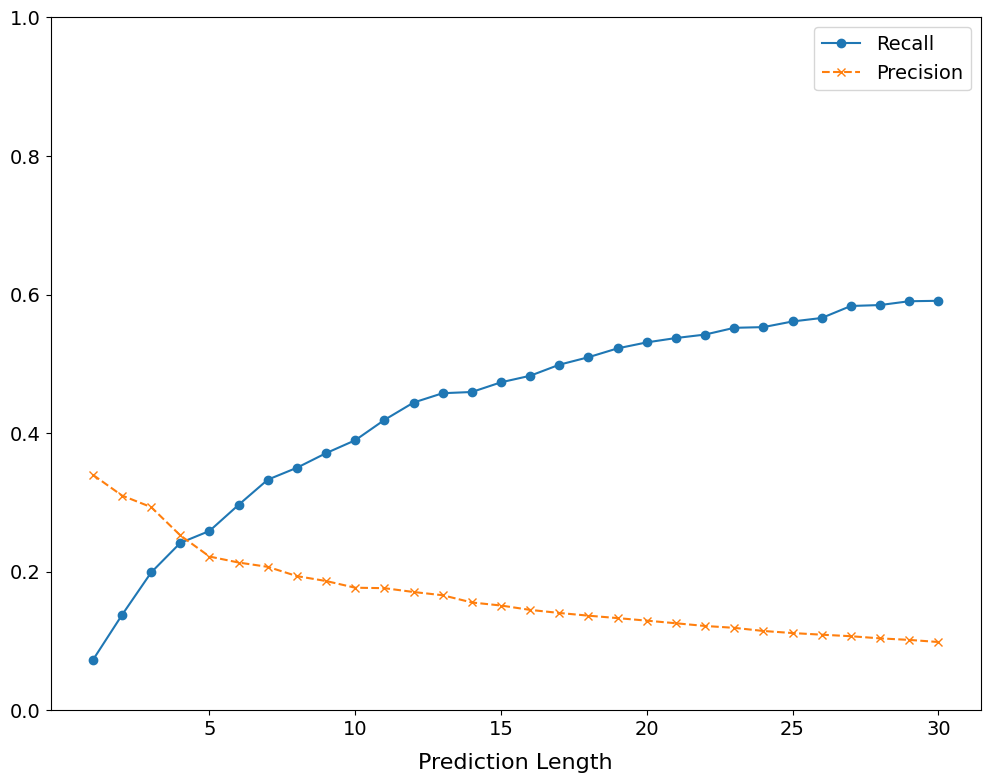

In [15]:
#Pharmacological category prediction task

fpdf = pd.read_csv(f"{main_folder}/Data/Representations_Annotated-Compounds/KRFP.csv")
fpdf = fpdf.drop_duplicates('cid').reset_index(drop=True)

cmpd_annot = pd.read_csv(f"{main_folder}/Data/Annotations/Annotated-Compound_Annotations.csv")

testset_name = "Annocom" ##Change the name of sameple dataset

all_results = []

folder = f"{main_folder}/Data/Sample_datasets/{testset_name}_Testset"
file_list = glob.glob(f"{folder}/*")

cids = fpdf['cid']
atcs = cmpd_annot['annot'].unique()

Mds = fpdf.loc[:, 'KRFP_1':'KRFP_4860']
Mds.index = fpdf['cid']

for f in tqdm(file_list[0:2]):
    testset = pd.read_csv(f)
    test_cids = testset['cid'].tolist()

    Mda = pd.DataFrame(0, index=cids, columns=atcs)

    train_cids = fpdf[~fpdf['cid'].isin(testset['cid'].tolist())]['cid'].tolist()

    for id in train_cids:
        try:
            drug_atcs = cmpd_annot[cmpd_annot['cid']==id]['annot'].tolist()
            for a in drug_atcs:
                Mda.loc[id, a] = 1
        except:
            pass

    c1 = np.vstack((np.zeros((Mda.shape[0], Mda.shape[0])), np.array(Mds.T), np.array(Mda.T)))
    c2 = np.vstack((np.array(Mds), np.zeros((Mds.shape[1]+Mda.shape[1], Mds.shape[1]))))
    c3 = np.vstack((np.array(Mda), np.zeros((Mds.shape[1]+Mda.shape[1], Mda.shape[1]))))
    w1 = np.hstack((c1, c2, c3))
    r1 = w1.copy()
    for i in range(0, w1.shape[0]):
        denom = sum(w1[i])
        for j in range(0, w1.shape[1]):
            if denom != 0:
                new = w1[i,j]/denom
                r1[i,j] = new
            
            else:
                r1[i,j] = 0
  
    r1k2 = np.linalg.matrix_power(r1, 2)
    y1 = np.matmul(w1, r1k2)
    DA_pred = Mda.copy()

    for i in range(0, len(Mda.index)):
        for j in range(0, len(Mda.columns)):
            DA_pred.iloc[i,j] = y1[i, (Mds.shape[0]+Mds.shape[1])+j]

    DA_pred = DA_pred.loc[test_cids,:]
    DA_pred = DA_pred.T

    results = pd.DataFrame()

    for l in range(1, 31):

        length = l
    
        for id in DA_pred.columns:
            row = results.shape[0]
            ans = cmpd_annot[cmpd_annot['cid']==id]['annot'].tolist()
            pred = list(DA_pred[id].sort_values(ascending=False).index[0:length])
            
            ranks = []
            score = 0
            for p in pred:
                if p in ans:
                    score += 1
                    ranks.append(pred.index(p)+1)
        
            results.loc[row, 'cid'] = id
            results.loc[row, 'correct_ans'] = str(ans)
            results.loc[row, 'ans_num'] = len(ans)
            results.loc[row, 'pred'] = str(pred)
            results.loc[row, 'pred_num'] = len(pred)
            results.loc[row, 'score'] = score
            results.loc[row,'av_rec'] = score/len(ans)
            results.loc[row, 'av_prec'] = score/len(pred)

            if len(ranks) > 0:
                results.loc[row, 'av_rank'] = sum(ranks)/len(ranks)
            else:
                results.loc[row, 'av_rank'] = np.nan

        all_results.append(results)

final_results = pd.concat(all_results, ignore_index=True)

#Plot

av_rec_values = final_results.groupby('pred_num')['av_rec'].mean()
av_prec_values = final_results.groupby('pred_num')['av_prec'].mean()


plt.figure(figsize=(12, 9))

plt.ylim(0.0, 1.0)

plt.plot(av_rec_values.index, av_rec_values, label='Recall', marker='o')
plt.plot(av_prec_values.index, av_prec_values, linestyle='--', label='Precision', marker='x')
plt.xlabel('Prediction Length', fontsize=16, labelpad=10)
plt.ylabel('')
plt.title('')
plt.legend()
plt.xticks(fontsize=14)
plt.xticks(np.arange(5, 31, 5))
plt.yticks(fontsize=14)
plt.legend(fontsize=14)


plt.show()